# Imports

In [129]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras import Input
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import load_model
import keras.ops
from keras import Loss

# Train on single vehicle dynamics

## Constant coefficient car

In [123]:
class SecondOrderCar:
    def __init__(self, x0: tuple, m: float, Af: float, to_estimate: tuple):
        #vehicle params:
        # known
        self.m = m 
        self.Af = Af
        #unkowns
        self.road_grade, self.c0, self.c1, self.p, self.Cd = to_estimate
    
        self.X = np.array(x0, dtype=float) #[position, velocity]

        self.history = {
            "x": [], "v": [], "u": [], "a": []
        }

    def update(self, u, dt):
        """Update state for one time step using fixed-step integration"""
        
        # Store history
        self.history['x'].append(self.X[0])
        self.history['v'].append(self.X[1])
        self.history['u'].append(u)
        

        # Rk4
        k1 = self._dynamics(self.X, u)
        a = k1[1] #gets v_dot = actual acceleration
        self.history["a"].append(a)

        k2 = self._dynamics(self.X + 0.5*dt*k1, u)
        k3 = self._dynamics(self.X + 0.5*dt*k2, u)
        k4 = self._dynamics(self.X + dt*k3, u)
        
        self.X += (dt/6) * (k1 + 2*k2 + 2*k3 + k4)

    def _dynamics(self, X, u):
        '''Vehicle Dynamics in State-Space form'''
        g = 9.81
        x, v = X
        Fr = (self.c0 + self.c1 * v)*(self.m*g*np.cos(self.road_grade))
        Fa = (self.p*self.Cd*self.Af*v**2)/2
        Fg = self.m*g*np.sin(self.road_grade)
        
        a = (u - Fr - Fa - Fg)/self.m #Assumes instant actuation u (traction force)
        return np.array([v, a])
    

## Generate synthetic data

In [135]:
# random value from https://www.chegg.com/homework-help/questions-and-answers/top-speed-vehicle-analytical-toolbox-consider-typical-sedan-car-following-parameters-mass--q109159050
x0 = (0, 20/3.6) #at origin and 20km/h
m = 1500 #kg toyota prius 2001 curb weight
# https://en.wikipedia.org/wiki/Automobile_drag_coefficient
Af = 2.1 # average drag (cross sectional) area
Cd = 0.27 #toyota prius 2001
p = 1.204 #average air density
#rolling resistance:
c0 = 0.0075
c1 = 2*10**-4
road_grade = np.atan(2/100) #in radians, 2% slope
to_estimate = (road_grade, c0, c1, p, Cd)

car = SecondOrderCar(x0, m, Af, to_estimate)
t_end = 300
dt = 0.1
t = np.arange(0, t_end+dt, dt)

#DEFINE U
t_samp = np.array([0, 40, 100, 200, 250, t_end]) #time check points
u_samp = np.array([0.5, 1, -0.2, 0.35, 0.3, 0.1]) * m # traction force (input from engine)
u = interp1d(t_samp, u_samp, kind='linear') #quadratic interpolation -> no drivetrain limitation for now

#generate data:
for t_curr in t:
    car.update(u(t_curr), dt)

## Simulate measurements (add noise)

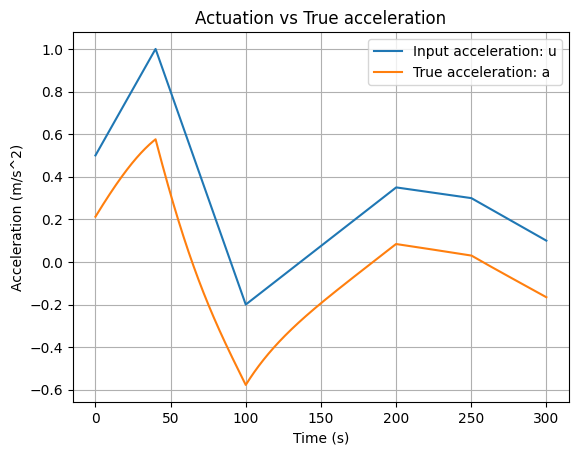

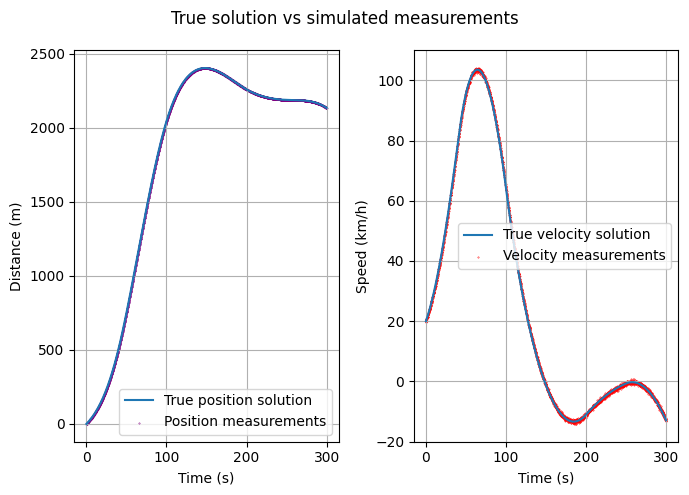

In [136]:
variance = 0.1

x_true = np.array(car.history["x"]).reshape(-1, 1)
v_true = np.array(car.history["v"]).reshape(-1, 1)
Y_true = np.hstack((x_true, v_true))
Y_noise = Y_true + np.random.normal(0, variance, size=Y_true.shape)

plt.plot(t, np.array(car.history["u"])/car.m, label = "Input acceleration: u")
plt.plot(t, car.history["a"], label="True acceleration: a")
plt.title("Actuation vs True acceleration")
plt.grid()
plt.legend();
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s^2)")
fig = plt.figure(figsize=(7,5))
fig.suptitle("True solution vs simulated measurements")
ax=fig.subplots(1,2)
ax[0].plot(t, Y_true[:, 0], label="True position solution")
ax[0].scatter(t, Y_noise[:, 0], label="Position measurements", s=0.1, color="purple")
ax[0].set_ylabel("Distance (m)")
ax[1].plot(t, Y_true[:, 1]*3.6, label="True velocity solution")
ax[1].scatter(t, Y_noise[:, 1]*3.6, label="Velocity measurements", s=0.1, color="red")
ax[1].set_ylabel("Speed (km/h)")
for i in range(len(ax)):
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel("Time (s)")
fig.tight_layout()

## Forward Problem

In [137]:
def comparison_plot(t, true_data: np.ndarray, meas_data: np.ndarray, pred_data: np.ndarray, suptitle: str, collocation_pts=[]):
    # Plot the true vs predicted values for position and velocity:
    plt.figure(figsize=(12,8))
    plt.suptitle(suptitle)
    # Plot for position:
    plt.subplot(1,2,1)
    plt.plot(t, true_data[:, 0], label="True Position", linewidth=2)
    plt.plot(t, pred_data[:, 0], '--', label="Predicted Position", linewidth=2)
    plt.scatter(t, meas_data[:, 0], label="Measured position points", s=1, color="red")
    plt.scatter(collocation_pts, np.zeros_like(collocation_pts), label="Collocation points",  marker="x", c="green")
    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.title("Position")
    plt.legend()
    plt.grid()

    # Plot for velocity:
    plt.subplot(1,2,2)
    plt.plot(t, true_data[:, 1]*3.6, label="True Velocity", linewidth=2)
    plt.plot(t, pred_data[:, 1]*3.6, '--', label="Predicted Velocity", linewidth=2)
    plt.scatter(t, meas_data[:, 1]*3.6, label="Measured velocity points", s=1, color="red")
    plt.scatter(collocation_pts, np.zeros_like(collocation_pts), label="Collocation points", marker="x", c="green")

    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (km/h)")
    plt.title("Velocity")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

def loss_plot(history, n_epochs):
    loss = history["loss"]
    val_loss = history["val_loss"]
    plt.plot(range(1,n_epochs+1), loss, label="Training Loss")
    plt.plot(range(1,n_epochs+1), val_loss, label="Validation Loss (against measurements)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid()
    plt.title("Evolution of training and validation losses")

# Prepping data

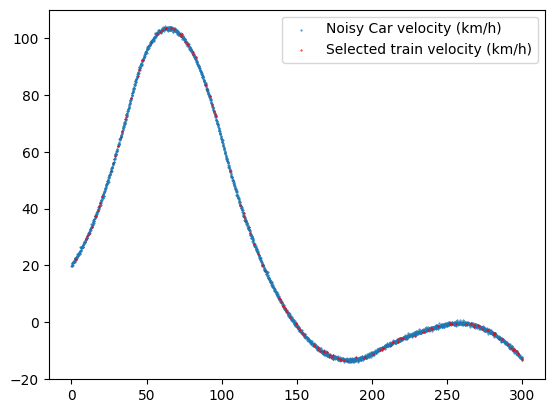

In [138]:
# prepping the data
train_ratio = .05
X = np.stack([t, u(t)], axis=-1) #t and u as features

Y_train, Y_test, X_train, X_test = train_test_split(Y_noise, X, train_size=train_ratio, random_state=31)
#print(Y_train.shape) #only 10% of measurements (sparse dataset)

#Visualize training data provided to model:
mask = np.isin(Y_noise, Y_train)
Y_mask = Y_noise.copy()
Y_mask[~mask] = np.nan
plt.scatter(t, Y_noise[:, 1] * 3.6, label="Noisy Car velocity (km/h)", s=.2)
plt.scatter(t, Y_mask[:, 1] * 3.6, label="Selected train velocity (km/h)", s=.2, color="red")
plt.legend()
plt.show()

#Prediction Normalization -> normal probably is a good dist
# if we dont do this, position contributes more to the loss, due to the sheer inbalance of scale
scaler_Y = StandardScaler().fit(Y_train)
Y_train_norm = scaler_Y.transform(Y_train)
Y_test_norm = scaler_Y.transform(Y_test)
Y_true_norm = scaler_Y.transform(Y_true)
y_0 = Y_true_norm[0, :]
# feature normalization all based on the training distribution
scaler_X = MinMaxScaler().fit(X_train)
X_train_norm = scaler_X.transform(X_train)
X_test_norm = scaler_X.transform(X_test)
X_norm = scaler_X.transform(X)
x_0_norm = X_norm[0, :]

## PUNN-only

In [108]:
#globals
#------
n_hid_layers = 3
n_neurons = 50
act = "tanh"
epochs = 1000
metrics = []
opt = Adam(learning_rate=0.001, weight_decay=0.01)
loss = "mse"
#------

#PUNN
punn_model = Sequential()
punn_model.add(Input(shape=(2, ))) #input: t,u
for _ in range(0,n_hid_layers):
    punn_model.add(Dense(n_neurons, activation=act))
punn_model.add(Dense(2, activation="linear")) #output layer -> p^ and v^
punn_model.compile(optimizer=opt, metrics=metrics, loss=loss)
#punn_model.summary()
history_punn_fwd = punn_model.fit(x=X_train_norm, y=Y_train_norm, validation_data=(X_norm, Y_true_norm), 
                                  batch_size=16, epochs=epochs, verbose=True)

Epoch 1/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - loss: 0.8705 - val_loss: 0.6357
Epoch 2/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.6138 - val_loss: 0.4078
Epoch 3/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.3542 - val_loss: 0.3260
Epoch 4/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.3182 - val_loss: 0.3319
Epoch 5/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.3471 - val_loss: 0.3115
Epoch 6/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.3168 - val_loss: 0.3051
Epoch 7/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.3046 - val_loss: 0.2984
Epoch 8/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.3302 - val_loss: 0.2923
Epoch 9/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.2799 - val_loss: 0.2863
Epoch 10/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.2796 - val_loss: 0.2823
Epoch 11/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.2928 - val_loss: 0.2765
Epoch 12/1000
10/10 ━━━━━━━━━━━━━━━━━━━━

In [109]:
punn_model.save("punn_model_forward.h5")

## PUNN predictions
Very nice for training u but change it and see the model totally fail :-)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Normalized MSE overall: 0.00029
Normalized MSE for position: 0.00019
Normalized MSE for velocity: 0.00039


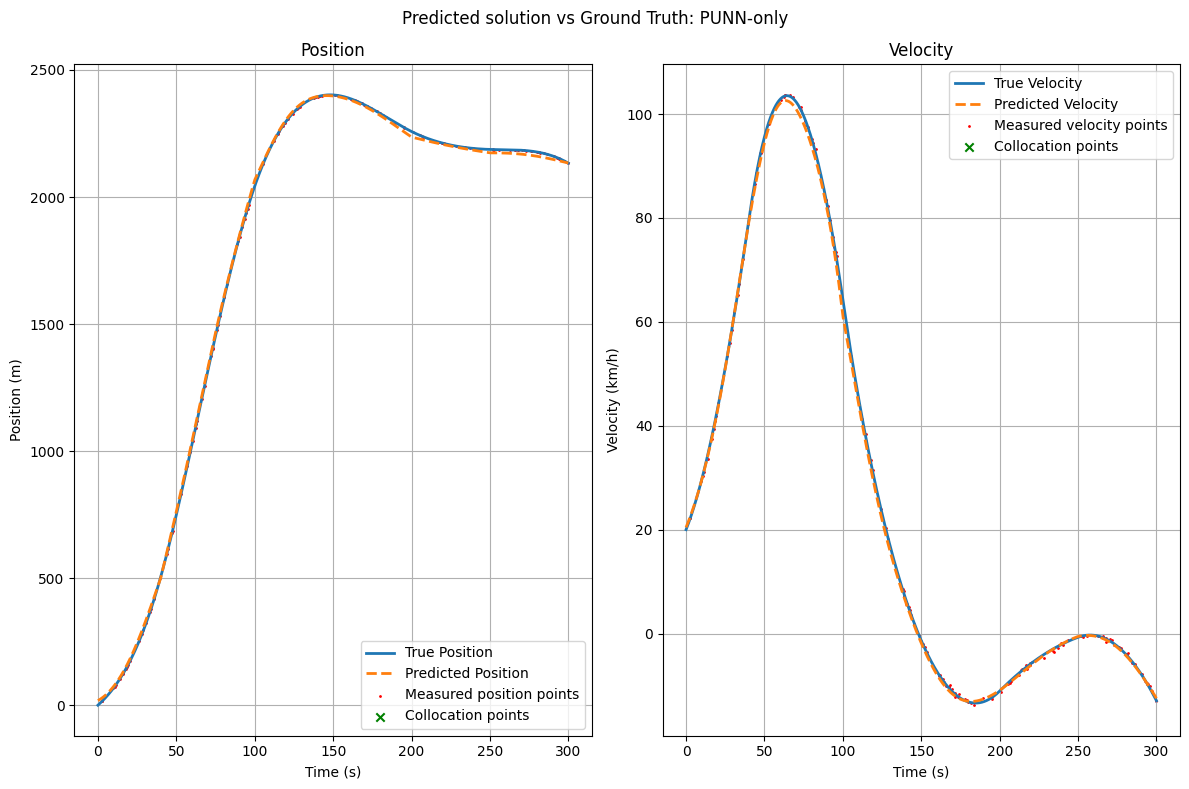

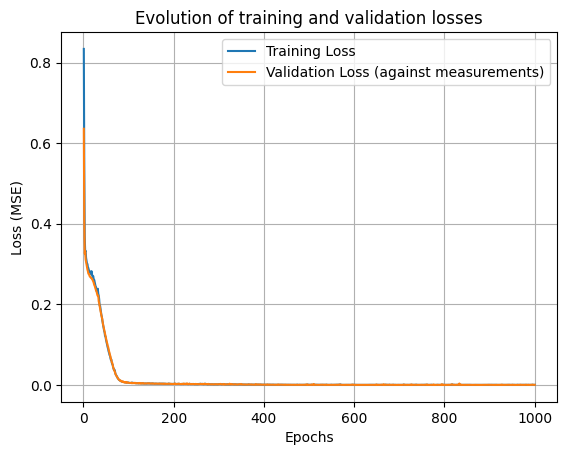

In [142]:
#punn_model = load_model("punn_model_forward.h5", compile=False) #load model just for prediction
#predictions for full t range
predictions_norm = punn_model.predict(X_norm)   #predictions shape will be (3000, 2)
predictions = scaler_Y.inverse_transform(predictions_norm) #denormalize for true trajectories 

mse_total = mean_squared_error(Y_true_norm, predictions_norm)
mse_x = mean_squared_error(Y_true_norm[:, 0], predictions_norm[:, 0])
mse_v = mean_squared_error(Y_true_norm[:, 1], predictions_norm[:, 1])
print(f"Normalized MSE overall: {mse_total:.5f}")
print(f"Normalized MSE for position: {mse_x:.5f}")
print(f"Normalized MSE for velocity: {mse_v:.5f}")

comparison_plot(t, Y_true, Y_mask, predictions, "Predicted solution vs Ground Truth: PUNN-only")
loss_plot(history_punn_fwd.history, epochs)


## PINN

#### Combined Loss

In [153]:
collocation_size = X_train_norm.shape[0] #same length as training time instants (for now)
t_c = np.linspace(start=0, stop=t_end, num=collocation_size) #collocation points -> uniform sampling for now
u_c = u(t_c)
X_c = np.stack([t_c, u_c], axis=-1)
X_c_norm = scaler_X.transform(X_c)

class CombinedLoss(Loss):
    def __init__(self, car, model: keras.Model, X_c_norm: np.ndarray, y_0: np.ndarray, x_0_norm: np.ndarray, 
                 scaler_X: MinMaxScaler, scaler_Y, t_end: float, loss_weights: tuple[float, float, float]):
        super().__init__()
        self.car = car
        self.model = model
        self.X_c_norm = tf.convert_to_tensor(X_c_norm, dtype=tf.float32)
        self.alpha_d, self.alpha_p, self.alpha_b = loss_weights
        self.t_end = t_end
        #initial conditions
        self.y_0 = y_0
        self.x_0_norm = x_0_norm
        self.scaler_Y = scaler_Y
        self.scaler_X = scaler_X

    def data_loss(self, y_true, y_pred):
        sqr_diff = keras.ops.square(y_true - y_pred)
        return keras.ops.mean(sqr_diff)

    def physics_loss(self):
        g = 9.81
        car = self.car
        u = self.scaler_X.inverse_transform(self.X_c_norm)[:, 1] #coonvert u to physic units again 

        with tf.GradientTape(persistent=True) as tape: #automatic differentiation
            tape.watch(self.X_c_norm) #record gradients for all time collocation points (normalized)
            #we need the model for prediction since collocation points might not be training points!
            predictions_norm = self.model(self.X_c_norm) 
            predictions = self.scaler_Y.inverse_transform(predictions_norm) #DENORMALIZE outputs
            x_pred = predictions[:, 0] 
            v_pred = predictions[:, 1]
        # gradients w.r.t normalized inputs
        grad_x = tape.gradient(x_pred, self.X_c_norm) 
        grad_v = tape.gradient(v_pred, self.X_c_norm)
        del tape
        
        #gradient w.r.t to time (denormalized)
        #chain rule: dx/dt_real = dx/dt_norm * dt_norm/dt_real. Since t_norm=t_real/t_end...
        dx_dt = grad_x[:, 0] / self.t_end
        dv_dt = grad_v[:, 0] / self.t_end

        Fr = (car.c0 + car.c1*v_pred)*(car.m*g*np.cos(car.road_grade))
        Fa = (car.p*car.Cd*car.Af*v_pred**2)/2
        Fg = car.m*g*np.sin(car.road_grade)

        res_x = dx_dt-v_pred
        res_v = car.m * dv_dt - (u - Fr - Fa - Fg)
        res = keras.ops.stack([res_x, res_v], axis=-1)

        sqr_diff = keras.ops.square(res)
        return keras.ops.mean(sqr_diff)

    def boundary_loss(self):
        y0_pred = self.model(self.x_0_norm[np.newaxis, :]) # add None batch dimension
        sqr_diff = keras.ops.square(y0_pred - self.y_0)
        return keras.ops.mean(sqr_diff)

    def call(self, y_true, y_pred):
        data_loss = self.data_loss(y_true, y_pred)
        pde_loss = self.physics_loss()
        bound_loss = self.boundary_loss()

        return self.alpha_d*data_loss + self.alpha_p*pde_loss + self.alpha_b*bound_loss


#### Training

In [154]:
#globals
#------
n_hid_layers = 3
n_neurons = 50
act = "tanh"
epochs = 1000
metrics = []
opt = Adam(learning_rate=0.001, weight_decay=0.01)
alpha_d = 1
alpha_p = 1
alpha_b = 1
alpha = alpha_d, alpha_p, alpha_b #weights for different loss components
#------

#PINN
pinn_model = Sequential()
pinn_model.add(Input(shape=(2, ))) #input: t andu« u
for _ in range(0,n_hid_layers):
    pinn_model.add(Dense(n_neurons, activation=act))
pinn_model.add(Dense(2, activation="linear")) #output layer -> p^ and v^
loss = CombinedLoss(car=car, model=pinn_model, X_c_norm=X_c_norm, scaler_X=scaler_X,
                    scaler_Y=scaler_Y, t_end=t_end, loss_weights=alpha, x_0_norm=x_0_norm, y_0=y_0_norm)
pinn_model.compile(optimizer=opt, metrics=metrics, loss=loss)
#pinn_model.summary()

history_pinn_fwd = pinn_model.fit(x=X_train_norm, y=Y_train_norm, validation_data=(X_norm,Y_true_norm), 
                                  batch_size=16, epochs=epochs, verbose=True)

Epoch 1/1000


NotImplementedError: Cannot convert a symbolic tf.Tensor (compile_loss/combined_loss_21/sequential_33_1/dense_135_1/BiasAdd:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.

In [96]:
pinn_model.save("pinn_model_forward.h5")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


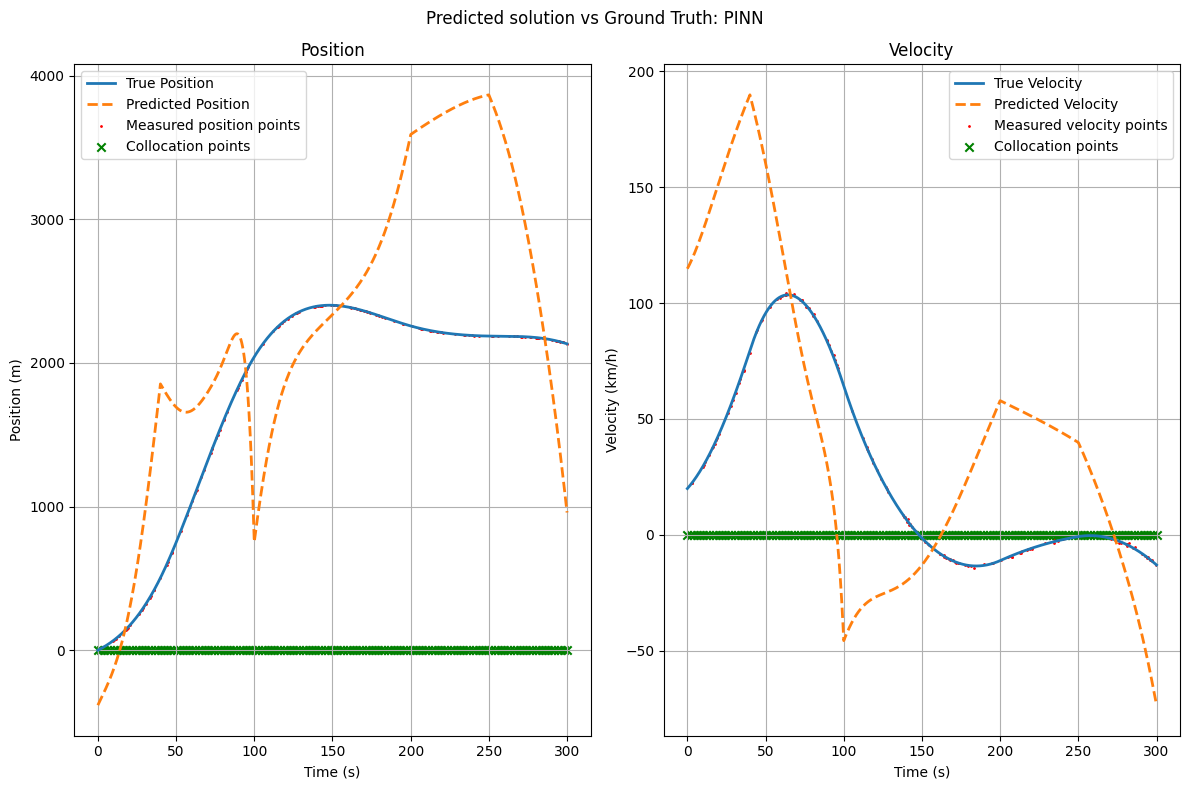

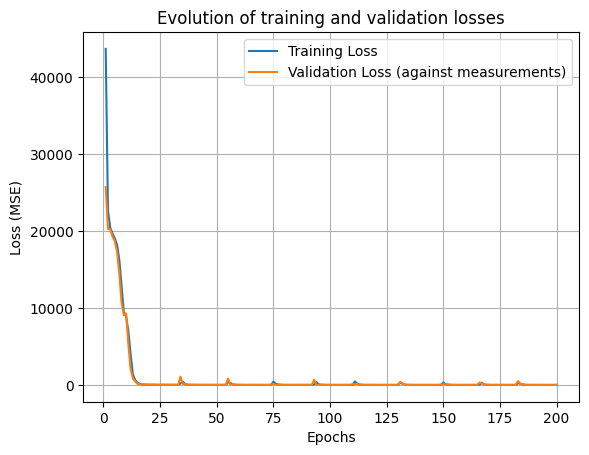

In [97]:
#pinn_model = load_model("pinn_model_forward.h5", compile=False) #load model just for prediction
#predictions for full t range
predictions_norm = pinn_model.predict(X_norm)   #predictions shape will be (3000, 2)
predictions = predictions_norm * std_Y_train + mean_Y_train 

comparison_plot(t, Y_true, Y_mask, predictions, collocation_pts=t_c, suptitle="Predicted solution vs Ground Truth: PINN")
loss_plot(history_pinn_fwd.history, epochs)
